### Medium story link (https://medium.com/@denizdoruknuholu/airbnb-in-two-cities-seattle-vs-boston-66fba22fc1c1)

In [1]:
#Make necessary imports
import numpy as np
import pandas as pd
import seaborn as sns
from re import sub
from decimal import Decimal
from matplotlib import pyplot as plt
import datetime
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize, WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import tests as t
import re
import nltk
from sklearn.preprocessing import OneHotEncoder
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dnuho\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dnuho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dnuho\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Business Understanding

#### AirBnB Kaggle data has three main files. Calendar data for both cities has pricing and availability over time that can be very useful in analyzing changes in these factors throughout the year. We could look into the means for both cities over time to generate insights and comparisons.

#### Listings data has another vitally important information for us, which is the review scores rating. I am thinking that looking at the correlation between words used in the comments for the listing, could give us great insights.

## 2. Data Understanding

In [2]:
#Read Listing and Calendar files for Boston & Seattle datasets
boston_listings = pd.read_csv('boston/listings.csv')
seattle_listings = pd.read_csv('seattle/listings.csv')
boston_calendar = pd.read_csv('boston/calendar.csv', parse_dates=['date'])
seattle_calendar = pd.read_csv('seattle/calendar.csv', parse_dates=['date'])
boston_review = pd.read_csv('boston/reviews.csv')
seattle_review = pd.read_csv('seattle/reviews.csv')

# Drop columns found in boston dataset that are not in seattle dataset.
boston_drop_columns = [column for column in boston_listings.columns if column not in seattle_listings.columns]

for column in boston_drop_columns:
    boston_listings.drop(column,axis=1,inplace=True)

In [3]:
#Clean up the data
#Function converts price in a string in currency format to float
def clean_price(price):
    """Take in a string and return a float without the currency sign"""
    try:
        return float(sub(r'[^\d.]', '', price))
    except:
        return float(price)

seattle_calendar['price'] = seattle_calendar['price'].map(clean_price)
boston_calendar['price'] = boston_calendar['price'].map(clean_price)
seattle_calendar['day_of_year'] = seattle_calendar['date'].map(lambda x: x.timetuple().tm_yday)
boston_calendar['day_of_year'] = boston_calendar['date'].map(lambda x: x.timetuple().tm_yday)
seattle_calendar['available'] = seattle_calendar['available'].apply(lambda x: True if x == 't' else False)
boston_calendar['available'] = boston_calendar['available'].apply(lambda x: True if x == 't' else False)
avg_price_day_s = seattle_calendar.drop('listing_id',axis=1).groupby('day_of_year').mean()
avg_price_day_b = boston_calendar.drop('listing_id',axis=1).groupby('day_of_year').mean()
avg_price_date_s = seattle_calendar.drop(['listing_id','day_of_year'],axis=1).groupby('date').mean()
avg_price_date_b = boston_calendar.drop(['listing_id','day_of_year'],axis=1).groupby('date').mean()

In [4]:
print('The median house price in Boston is ${}'.format(int(boston_calendar['price'].median())))
print('The median house price in Seattle is ${}'.format(int(seattle_calendar['price'].median())))

The median house price in Boston is $150
The median house price in Seattle is $109


### Question 1: How are the pricing of the properties in Boston and Seattle? Do they have seasonality? Are there any events that cause jumps in price?

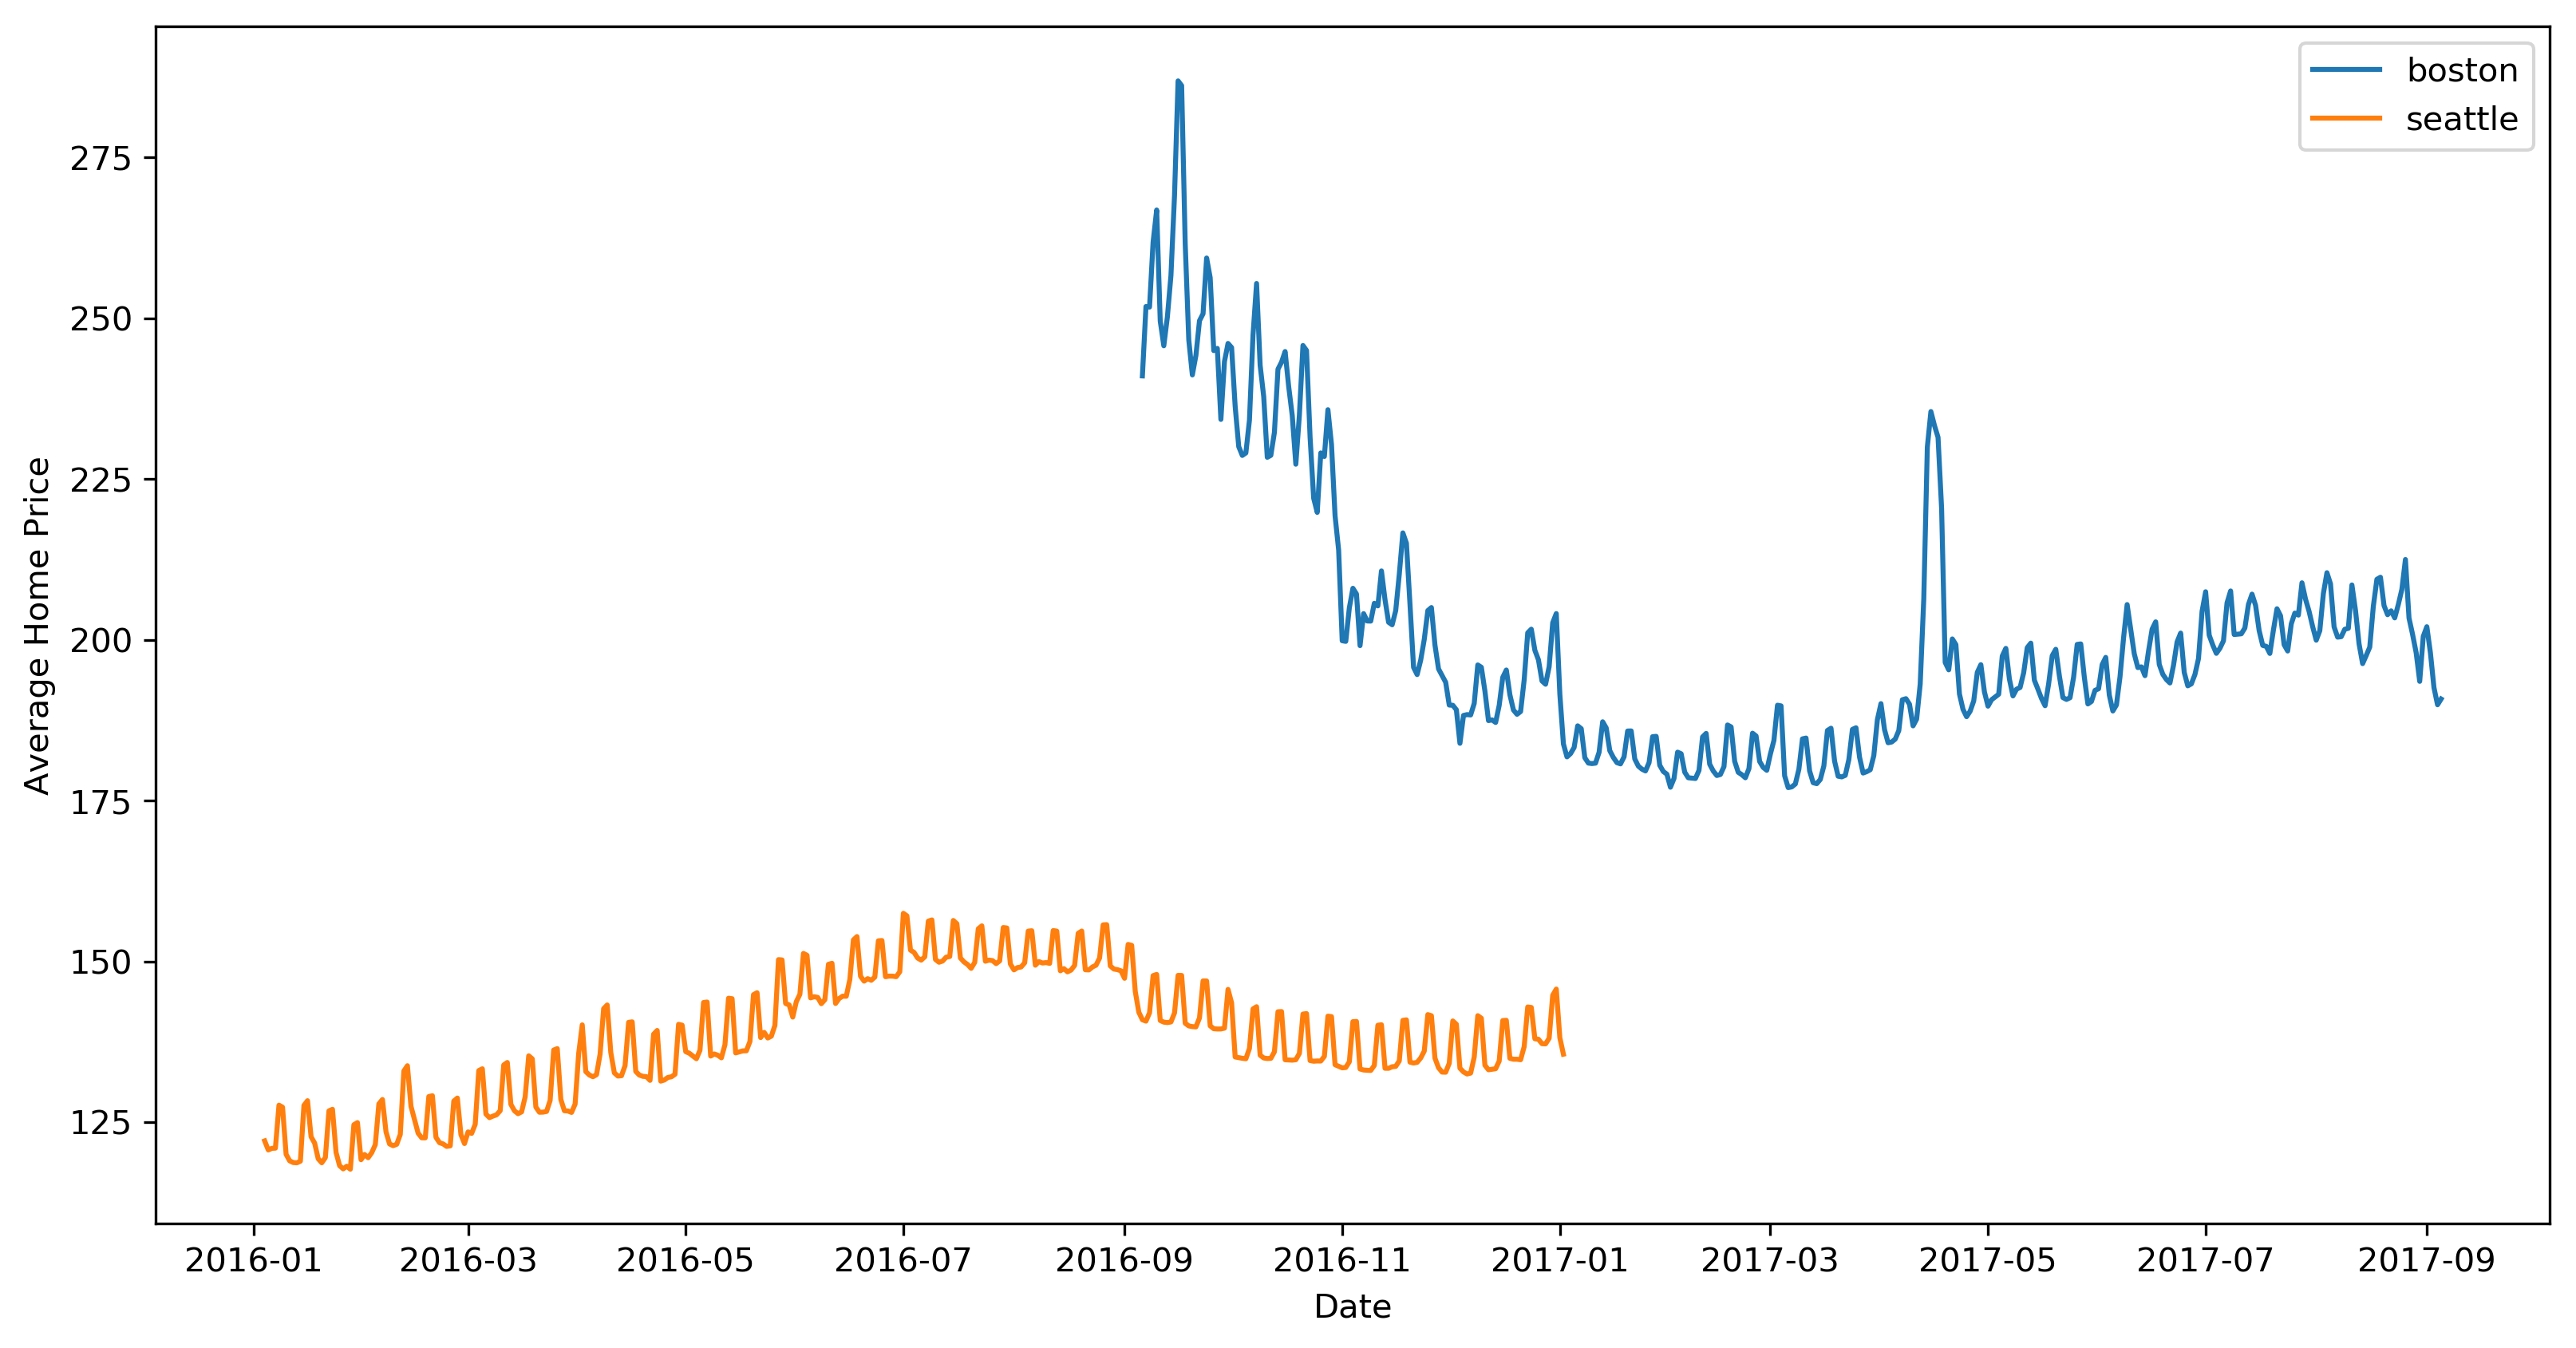

In [5]:
fig = plt.figure(figsize=(10,5),dpi=300)
ax = fig.add_axes([0,0,1,1])
ax.plot(avg_price_date_b['price'], label='boston')
ax.plot(avg_price_date_s['price'], label='seattle')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Average Home Price');
fig.savefig('png\PriceVsDate.png', bbox_inches='tight')

In [6]:
'The average price during the Boston Marathon period in 2017 was ${}'.format(int(avg_price_date_b.loc['2017-04-14':'2017-04-17','price'].mean()))

'The average price during the Boston Marathon period in 2017 was $232'

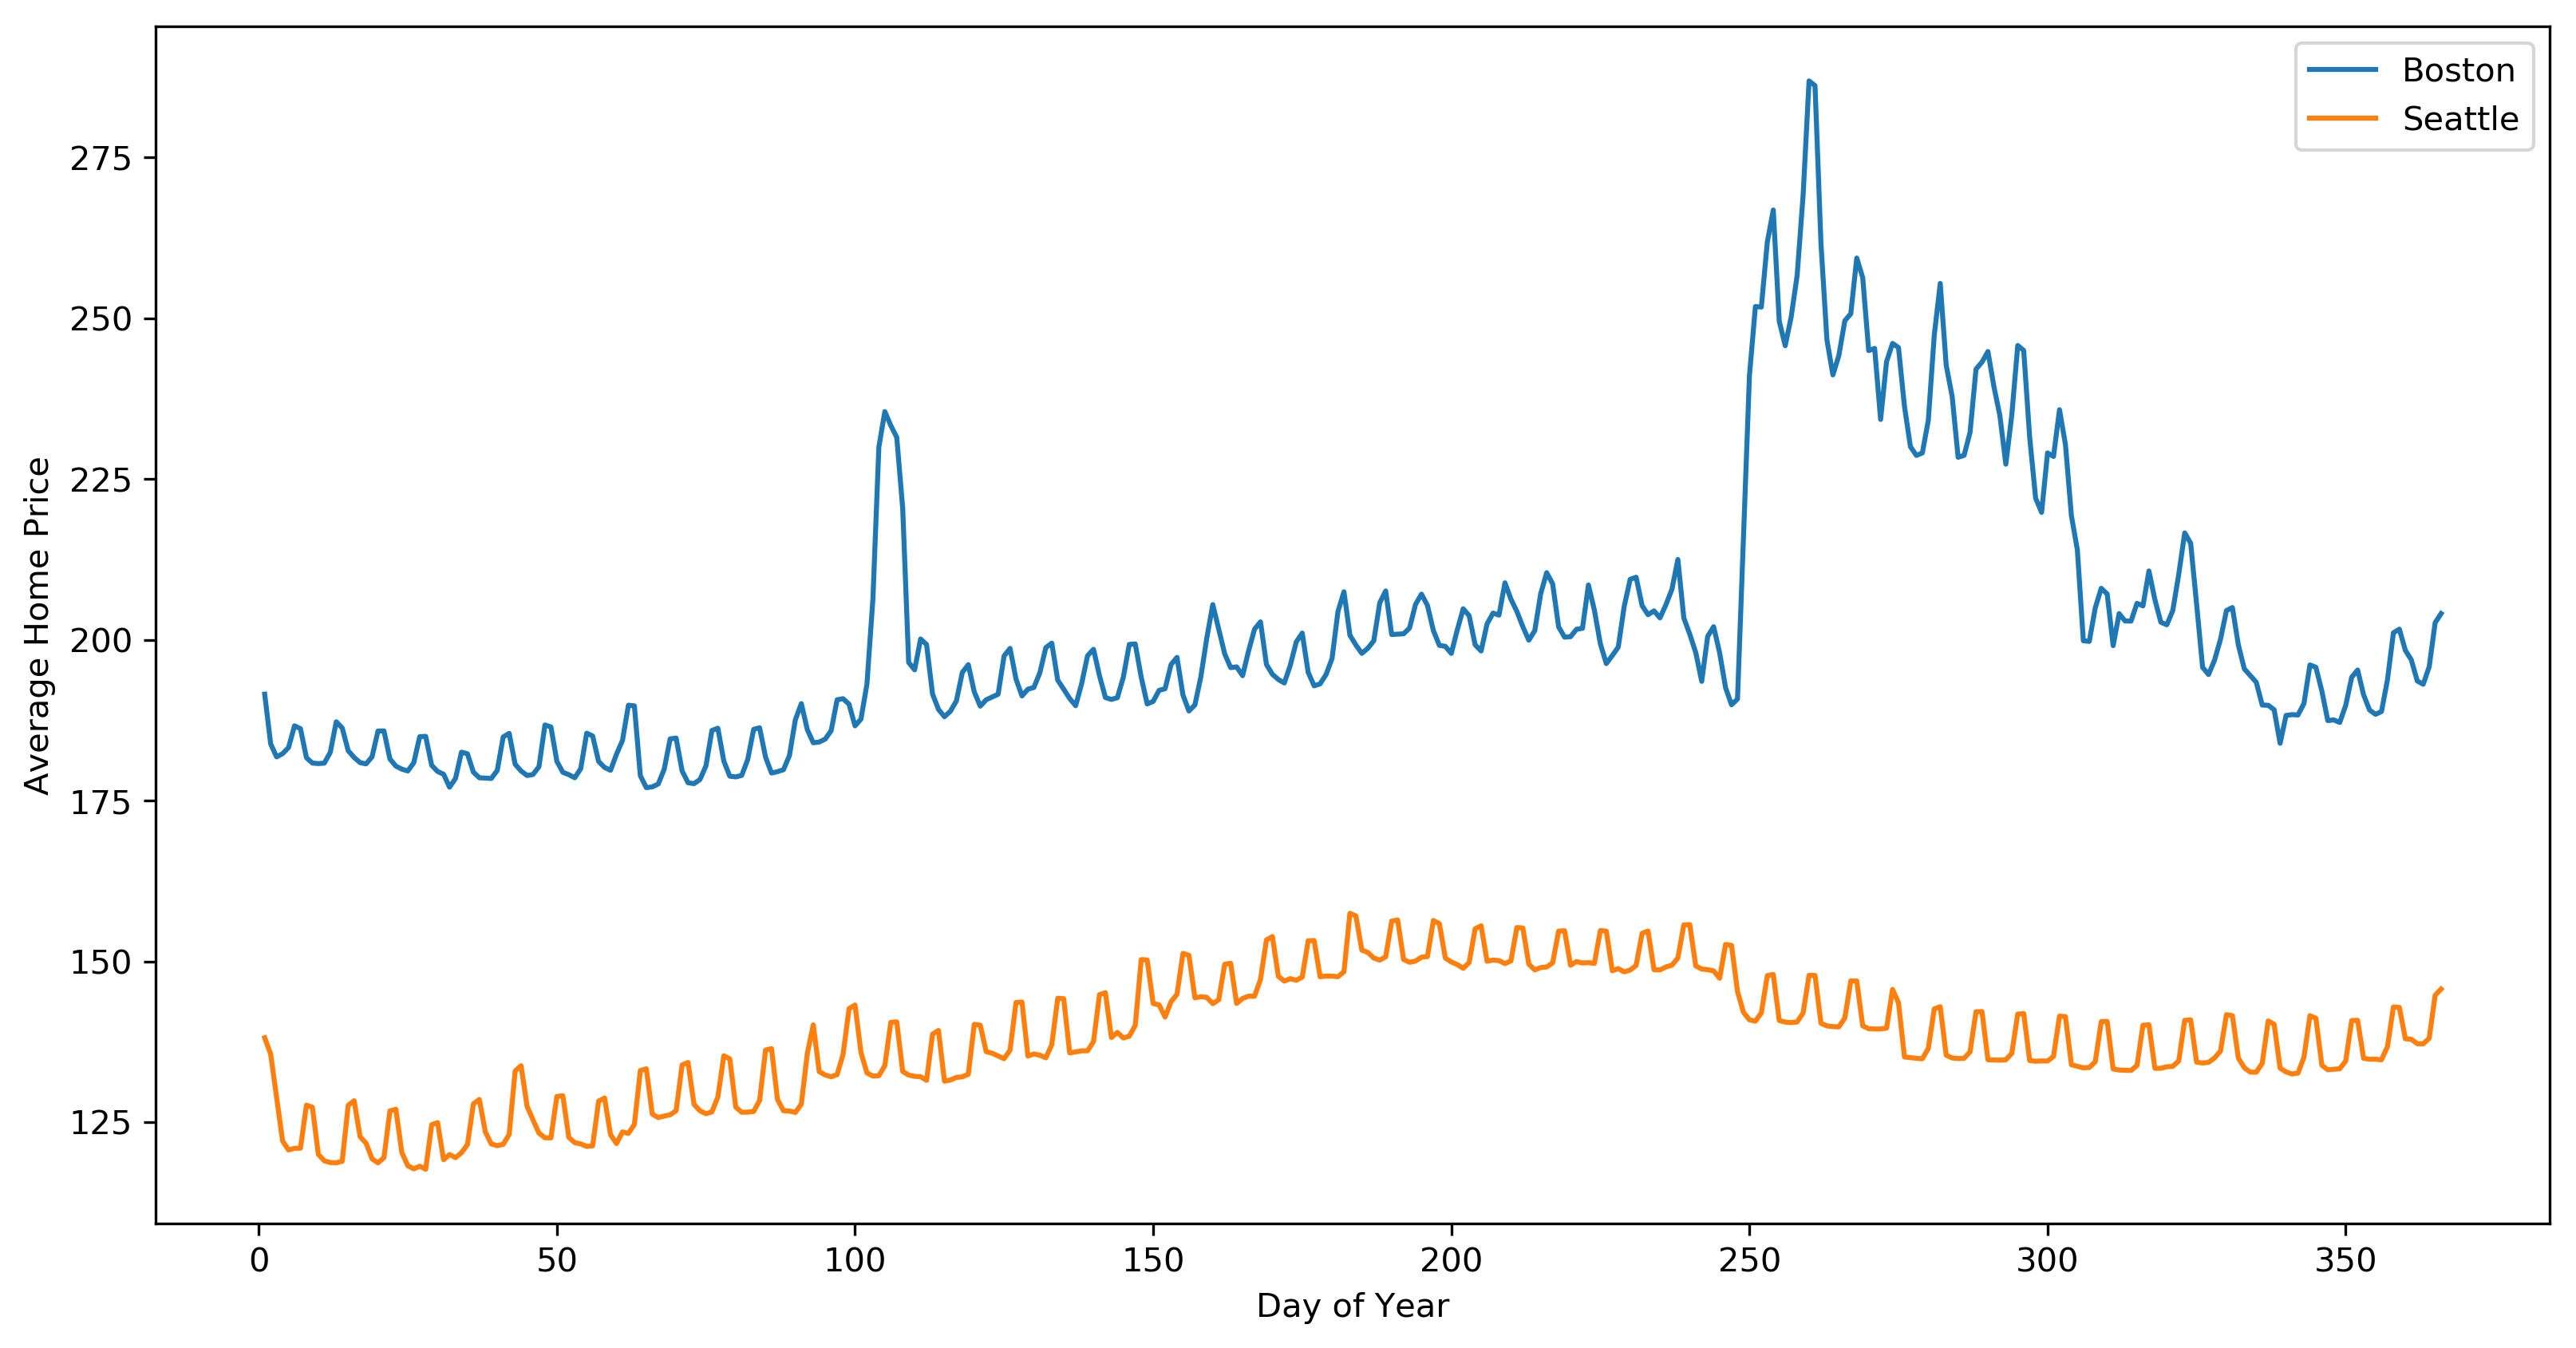

In [7]:
fig2 = plt.figure(figsize=(10,5),dpi=300)
ax2 = fig2.add_axes([0,0,1,1])
ax2.plot(avg_price_day_b['price'], label='Boston')
ax2.plot(avg_price_day_s['price'], label='Seattle');
ax2.legend()
ax2.set_xlabel('Day of Year')
ax2.set_ylabel('Average Home Price')
fig2.savefig('png\PricevsDay.png', bbox_inches='tight')

### Question 2: How is the availability of the properties in both cities throughout the year

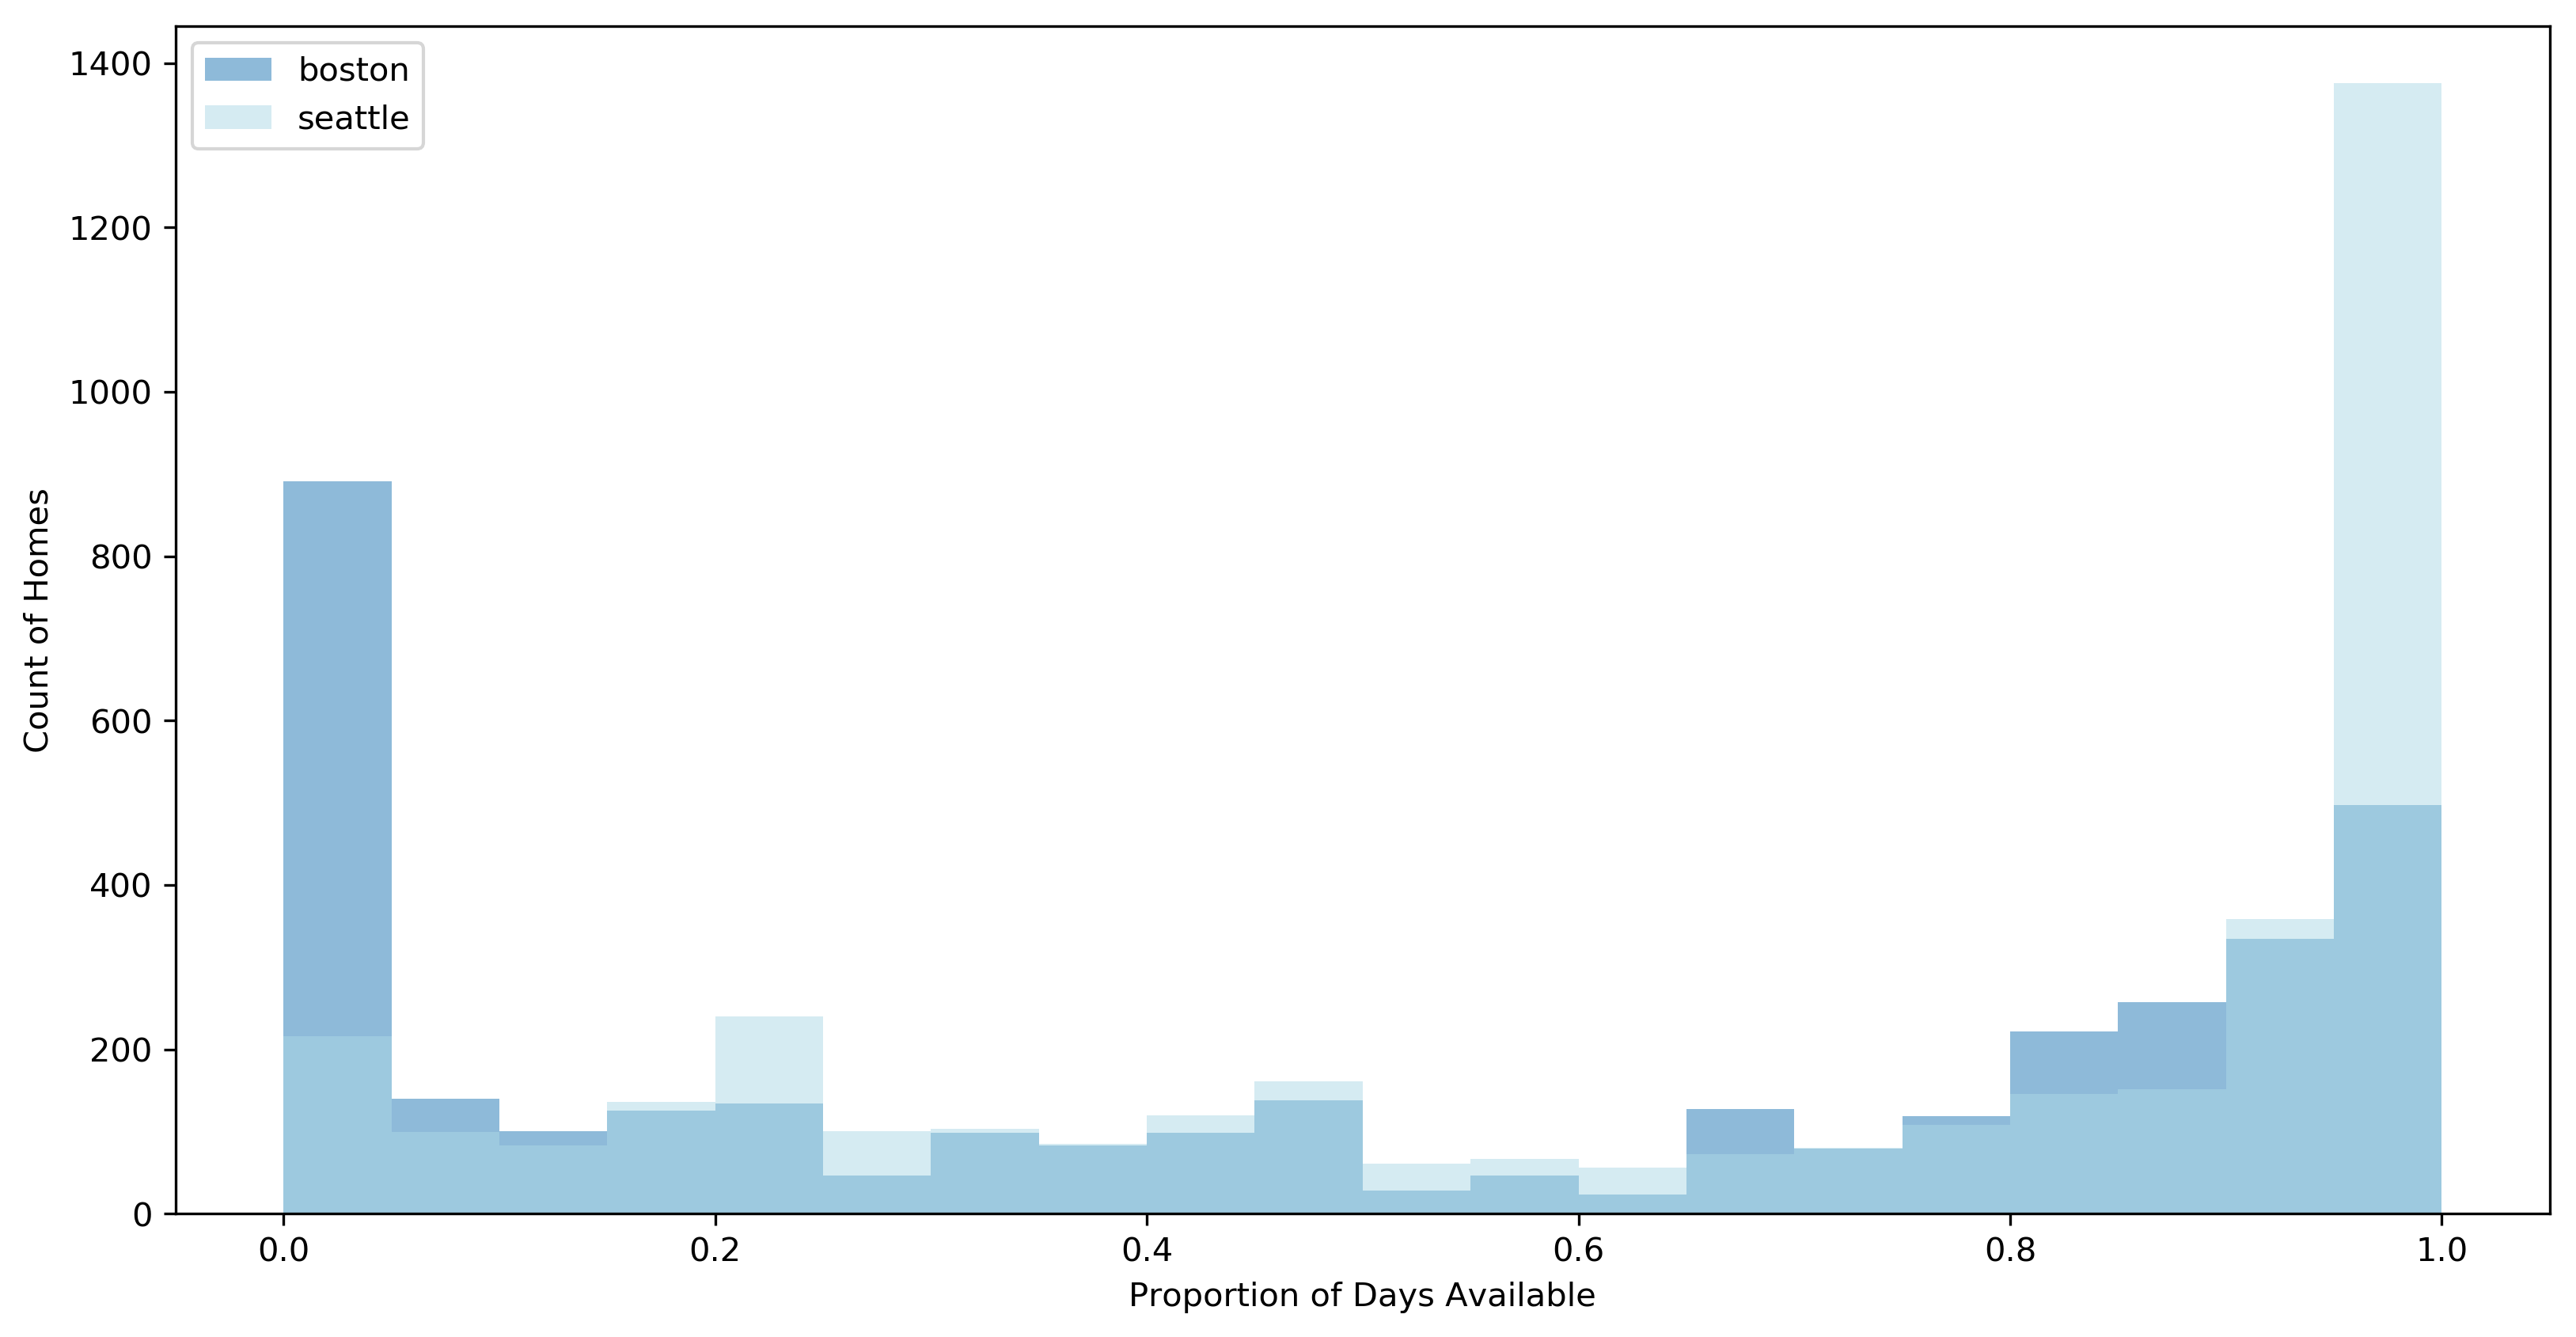

In [8]:
fig3 = plt.figure(figsize=(10,5),dpi=300)
ax3 = fig3.add_axes([0,0,1,1])
ax3.hist(boston_calendar.groupby('listing_id').mean()['available'],bins=20,alpha=0.5, label='boston');
ax3.hist(seattle_calendar.groupby('listing_id').mean()['available'],bins=20,alpha=0.5, label='seattle', color='lightblue')
ax3.legend()
ax3.set_xlabel('Proportion of Days Available')
ax3.set_ylabel('Count of Homes')
fig3.savefig('png\PropDaysAvailable.png', bbox_inches='tight')

In [9]:
'In Boston, at any given time, there is a %{} chance that a house is available, while in Seattle this figure is much higher at %{}'.format(int(boston_calendar['available'].mean()*100), int(seattle_calendar['available'].mean()*100))

'In Boston, at any given time, there is a %49 chance that a house is available, while in Seattle this figure is much higher at %67'

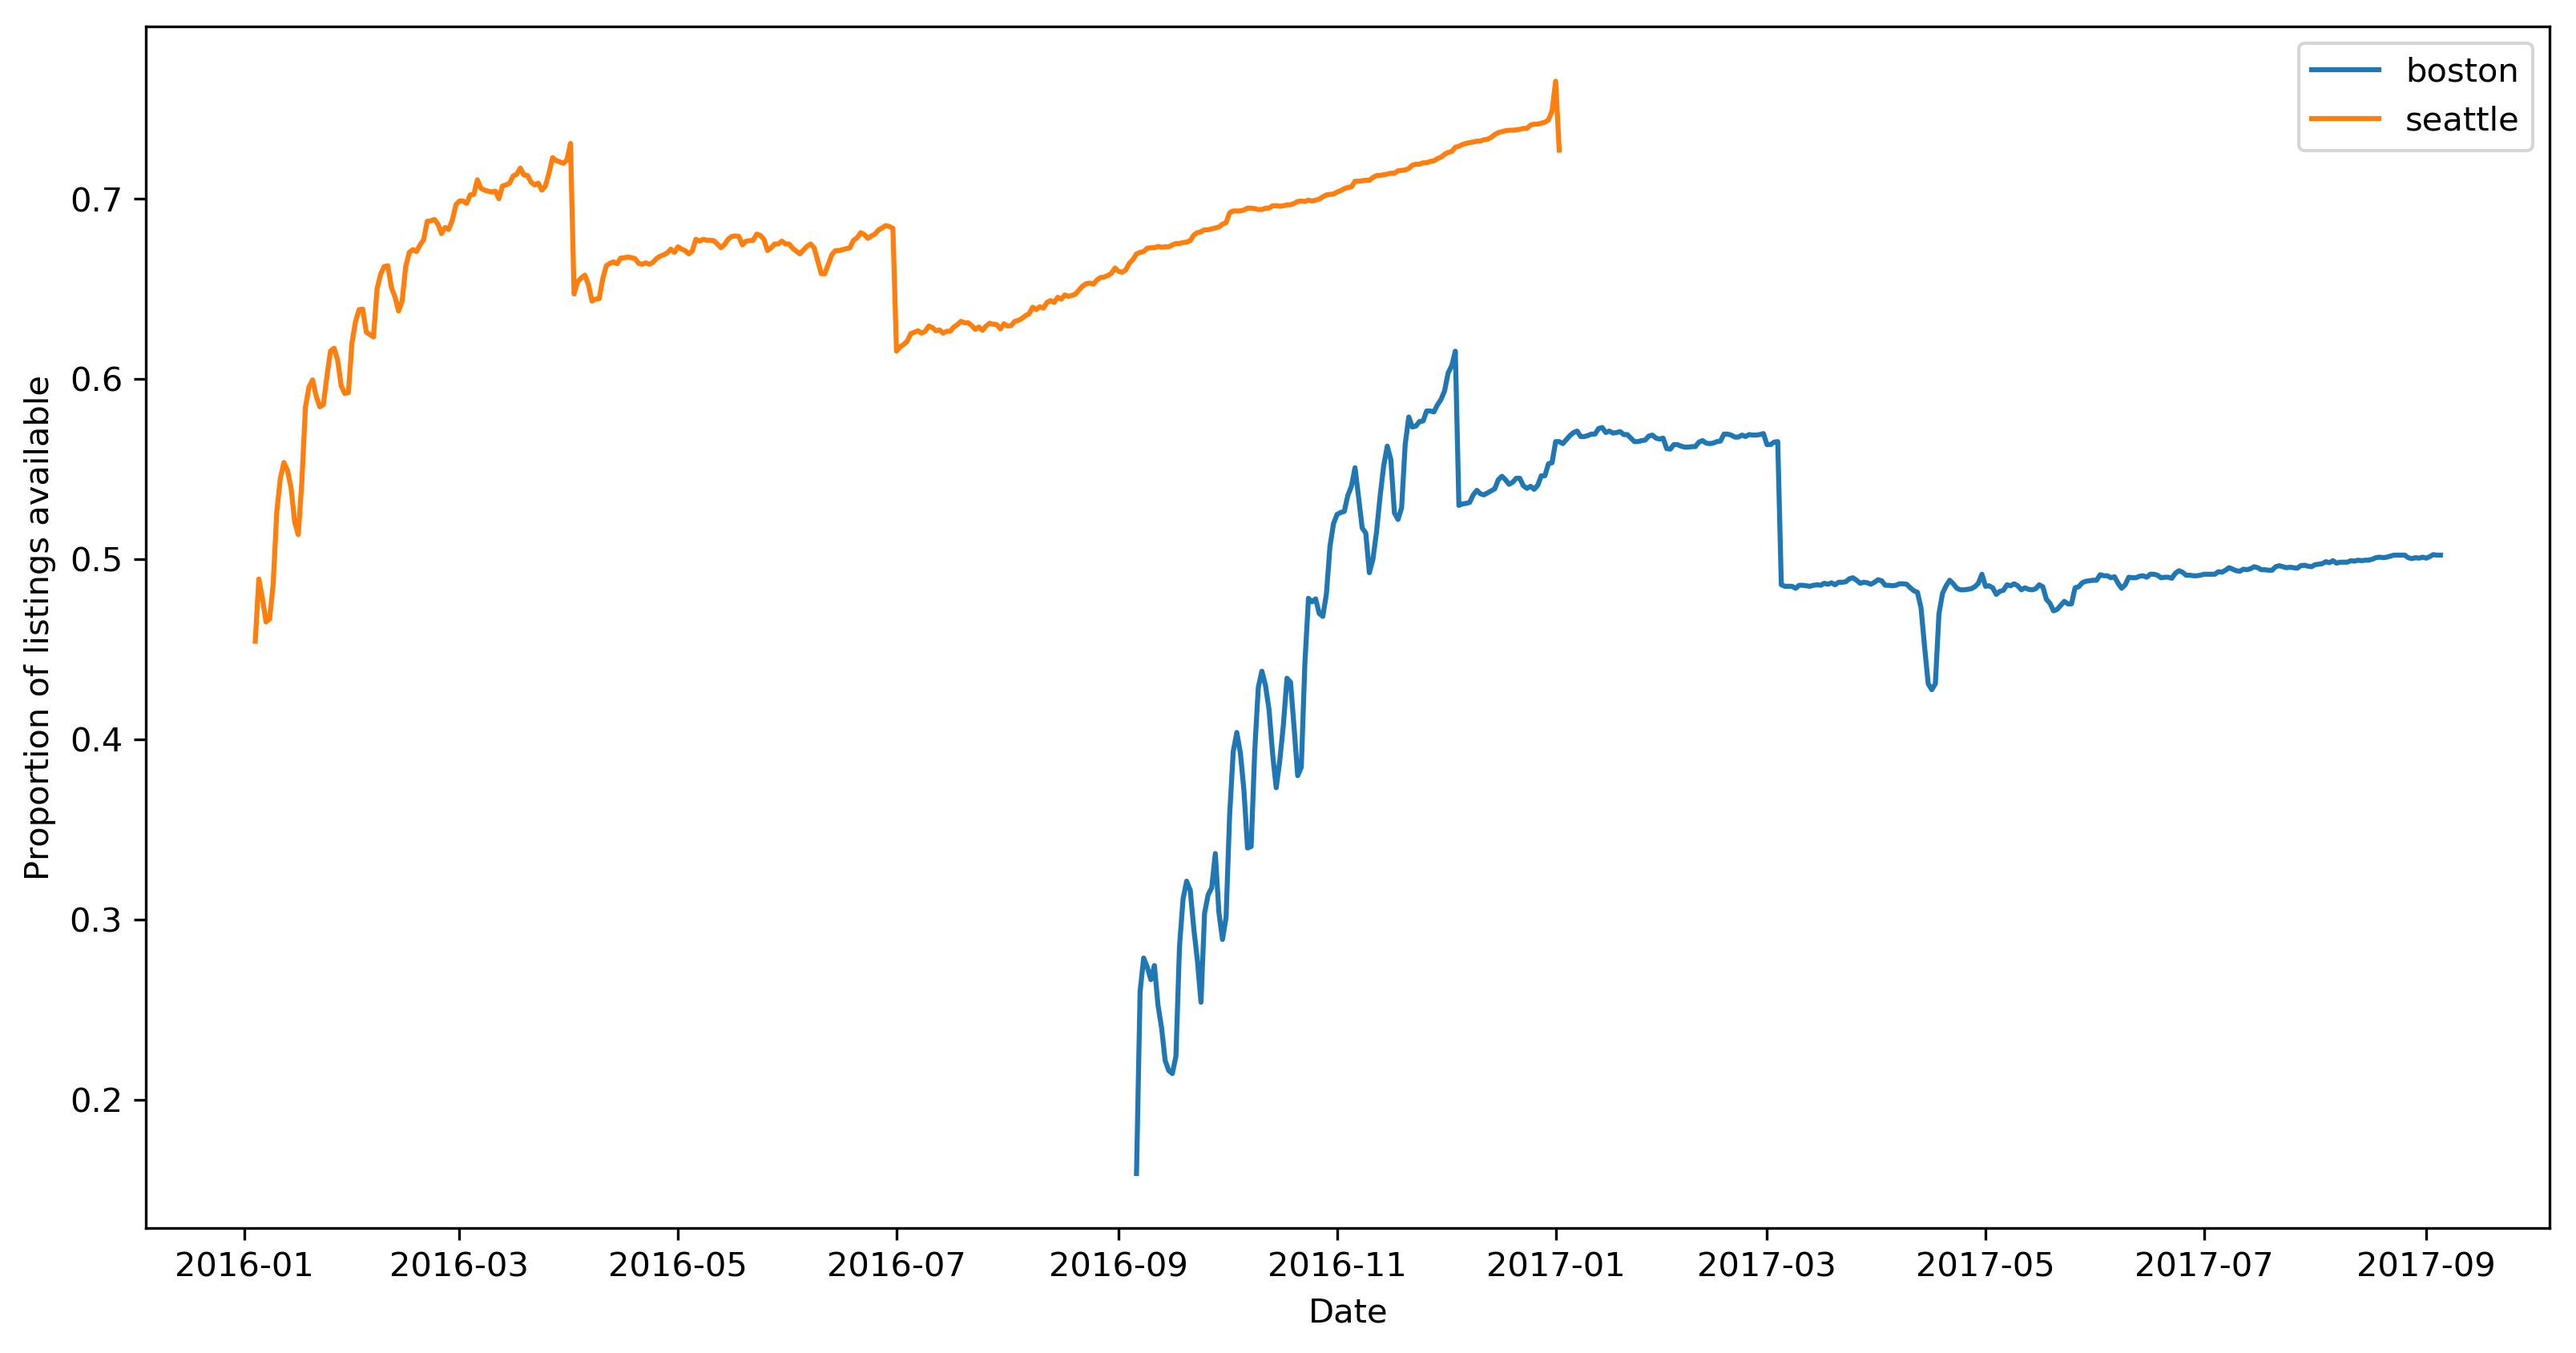

In [10]:
fig4 = plt.figure(figsize=(10,5),dpi=300)
ax4 = fig4.add_axes([0,0,1,1])
ax4.plot(boston_calendar.drop(['listing_id','price','day_of_year'],axis=1).groupby('date').mean(),label='boston')
ax4.plot(seattle_calendar.drop(['listing_id','price','day_of_year'],axis=1).groupby('date').mean(),label='seattle')
ax4.legend()
ax4.set_xlabel('Date')
ax4.set_ylabel('Proportion of listings available')
fig4.savefig('png\ListingsAvailableByDate.png', bbox_inches='tight')

### Question 3: Can we predict the review score from comments using regression? Do the comments of the visitors on a listing give us enough information for us to guess the review score of that listing

In [11]:
# Assess Seattle reviews table
seattle_review.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [12]:
# Assess Seattle listings table
seattle_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [13]:
# Assess Seattle review-specific columns of the reviews table
seattle_listings.loc[:,[column for column in seattle_listings.columns if 'review' in column]].head()

,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,4.07
1,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,1.48
2,20,2014-07-30,2015-09-03,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1.15
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,38,2012-07-10,2015-10-24,92.0,9.0,9.0,10.0,10.0,9.0,9.0,0.89


In [14]:
####  Below I create a reviews dataframe that concatenates all review strings into one per listing. Boston and Seattle data are also merged into one.

In [15]:
reviews = pd.DataFrame(columns=['comments'])

for item in seattle_review['listing_id'].unique():
        reviews.loc[item,'comments'] = seattle_review[seattle_review['listing_id']==item]['comments'].str.cat()

for item in boston_review['listing_id'].unique():
        reviews.loc[item,'comments'] = boston_review[boston_review['listing_id']==item]['comments'].str.cat()
        
review_score_rating = pd.concat([seattle_listings.loc[:,['id','review_scores_rating']],boston_listings.loc[:,['id','review_scores_rating']]])
reviews['review_scores_rating'] = reviews.index.map(review_score_rating.set_index('id')['review_scores_rating'])

In [16]:
# of listings without a valid review score
reviews.isnull().sum()

comments                 0
review_scores_rating    77
dtype: int64

In [17]:
# of listings without a valid review score that have a 'automated host cancellation message'
len([comment for comment in (reviews[reviews.isnull()['review_scores_rating']])['comments'] if 'auto' in comment])

76

## 3. Data Preparation

#### I will be dropping any reviews that have an NA value in either comments or scores for simplicity. There are 77 reviews with na review score, and 76 of them have been auto generated by system due to cancellation by the host.

#### Due to the low number of NA values, dropping these will not affect the data adversely.

In [18]:
reviews.dropna(inplace=True)

In [19]:
def preprocessor(text):
    """Takes in text, removes punctuation and returns it
    
    text (str) : Text to be preprocessed. Punctuation will be removed from the string and string will be returned.
    
    Returns:
    str: Text without any punctuation
    
    """
      
    text = re.sub(r"[^a-zA-Z0-9]"," ", text)
    text = re.sub(r"'","", text)
    return text

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

## Define tokenizer, splitting text into tokens, while also removing stopwords, applying stemming and lemmatization as well
def tokenizer(text):
    """Splits text into tokens, removes stopwords, lemmatizes and stems, then returns resulting tokens
    
    text (str) : String to be tokenized. Firstly the string will be split into tokens. Then, it will be stripped from stop words.
    Finally, lemmatization and stemming will be applied to each token
    
    Returns:
    list : Tokenized text in list format
    
    """
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    tokens = [stemmer.stem(lemmatizer.lemmatize(token)) for token in tokens]
    return tokens

#Initialize Vectorizers
CV = CountVectorizer(stop_words=None, tokenizer=tokenizer, preprocessor=preprocessor, lowercase=True)
TFIDF = TfidfVectorizer(stop_words=None, tokenizer = tokenizer, preprocessor=preprocessor, lowercase=True)

## 4. Modeling

In [20]:
#Initialize TFIDF Vectorizer with custom preprocessor and tokenizer
TFIDF = TfidfVectorizer(stop_words=None, tokenizer = tokenizer, preprocessor=preprocessor, max_features=1000)

#Create intermediate set which contains our train and validation sets, as well as
X_intermediate, X_test, y_intermediate, y_test = train_test_split(reviews['comments'], reviews['review_scores_rating'],
                                                                  shuffle=True,
                                                                  test_size=0.2)
#Set alphas and learning_rates to GridSearch upon for SGDR, XGBR and CatBoostReg
alphas = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
learning_rates = [1,0.1,0.01,0.001,0.0001,0.00001,0.000001]

kf = KFold(3, shuffle=True, random_state=21)

train_errors_sgdr = {a:[] for a in alphas}
val_errors_sgdr = {a:[] for a in alphas}
train_errors_xgb = {n:[] for n in learning_rates}
val_errors_xgb = {n:[] for n in learning_rates}
train_errors_cat = {n:[] for n in learning_rates}
val_errors_cat = {n:[] for n in learning_rates}


for train_index, val_index in kf.split(X_intermediate, y_intermediate):
    
    X_train, X_val = X_intermediate[X_intermediate.index[train_index]], X_intermediate[X_intermediate.index[val_index]]
    y_train, y_val = y_intermediate[y_intermediate.index[train_index]], y_intermediate[y_intermediate.index[val_index]]
    
    X_train = pd.DataFrame(TFIDF.fit_transform(X_train).toarray(), X_train.index)
    X_val = pd.DataFrame(TFIDF.transform(X_val).toarray(), X_val.index)
    
    #Stochastic Gradient Descent
    for alpha in alphas:
        #instantiate Stochastic Gradient Descent model and fit it
        sgdr = SGDRegressor(alpha=alpha, random_state=21, verbose=False).fit(X_train, y_train)
    
        #calculate errors
        yhat_train = sgdr.predict(X_train)
        yhat_val = sgdr.predict(X_val)
        train_error, val_error = mean_squared_error(y_train, yhat_train), mean_squared_error(y_val, yhat_val)
        train_errors_sgdr[alpha].append(train_error)
        val_errors_sgdr[alpha].append(val_error)
    
    for lr in learning_rates:
        
        # CatBoost Regressor
        cat = CatBoostRegressor(learning_rate=lr,random_seed=21,thread_count=10, verbose=False).fit(X_train, y_train)
        train_error_cat, val_error_cat = mean_squared_error(cat.predict(X_train), y_train), mean_squared_error(cat.predict(X_val), y_val)
        train_errors_cat[lr].append(train_error_cat)
        val_errors_cat[lr].append(val_error_cat)
        
        # XGBoost Regressor
        xgb = XGBRegressor(learning_rate=lr,random_seed=21,n_jobs=-1, verbose=False).fit(X_train, y_train)
        train_error_xgb, val_error_xgb = mean_squared_error(xgb.predict(X_train), y_train), mean_squared_error(xgb.predict(X_val), y_val)
        train_errors_xgb[lr].append(train_error_xgb)
        val_errors_xgb[lr].append(val_error_xgb)

C:\Anaconda3\envs\dsnd\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Anaconda3\envs\dsnd\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Anaconda3\envs\dsnd\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol

In [21]:
# Take the average of the three cross-validation results and store them into a table
# Save regression results into a .csv file for later

sgdr_train = pd.DataFrame(pd.Series({'sgdr{}'.format(a): np.mean(train_errors_sgdr[a]) for a in train_errors_sgdr}), columns=['Train Errors']).reset_index()
sgdr_val = pd.DataFrame(pd.Series({'sgdr{}'.format(a): np.mean(val_errors_sgdr[a]) for a in val_errors_sgdr}), columns=['Validation Errors']).reset_index()
cat_train = pd.DataFrame(pd.Series({'cat{}'.format(a): np.mean(train_errors_cat[a]) for a in train_errors_cat}), columns=['Train Errors']).reset_index()
cat_val = pd.DataFrame(pd.Series({'cat{}'.format(a): np.mean(val_errors_cat[a]) for a in val_errors_cat}), columns=['Validation Errors']).reset_index()
xgb_train = pd.DataFrame(pd.Series({'xgb{}'.format(a): np.mean(train_errors_xgb[a]) for a in train_errors_xgb}), columns=['Train Errors']).reset_index()
xgb_val = pd.DataFrame(pd.Series({'xgb{}'.format(a): np.mean(val_errors_xgb[a]) for a in val_errors_xgb}), columns=['Validation Errors']).reset_index()
regression_results_sgdr = pd.merge(sgdr_train, sgdr_val)
regression_results_cat = pd.merge(cat_train,cat_val)
regression_results_xgb = pd.merge(xgb_train, xgb_val)
regression_results = pd.concat([regression_results_sgdr, regression_results_cat, regression_results_xgb]).rename({'index':'regressor'},axis=1).set_index('regressor')
regression_results.to_csv('regression_results.csv')
regression_results

,Train Errors,Validation Errors
regressor,,
sgdr1,66.427867,66.480902
sgdr0.1,63.453267,63.580618
sgdr0.01,70.899820,71.550601
sgdr0.001,74.047102,74.902937
sgdr0.0001,74.417275,75.297298
sgdr1e-05,74.454905,75.337388
sgdr1e-06,74.458674,75.341404
cat1,6.484076,85.822258
cat0.1,14.029673,49.315698


## 5. Evaluation

### Fit the best performing regressor which is XGB with 0.1 learning rate to the train(intermediate) data and test it.

In [22]:
X_intermediate_tf = pd.DataFrame(TFIDF.fit_transform(X_intermediate).toarray(), X_intermediate.index)
X_test_tf = pd.DataFrame(TFIDF.transform(X_test).toarray(), X_test.index)
best_regressor = XGBRegressor(learning_rate=0.1, random_state=21, n_jobs=-1).fit(X_intermediate_tf,y_intermediate)
yhat_test = best_regressor.predict(X_test_tf)
best_score = mean_squared_error(y_test, yhat_test)
print('The test result for our best estimator is MSE:{}'.format(best_score))

The test result for our best estimator is MSE:43.64838362373505


### Below is a comparison of the actuals of the first 200 listings in our test dataset, as well as the predictions of our best estimator. (Visualize)

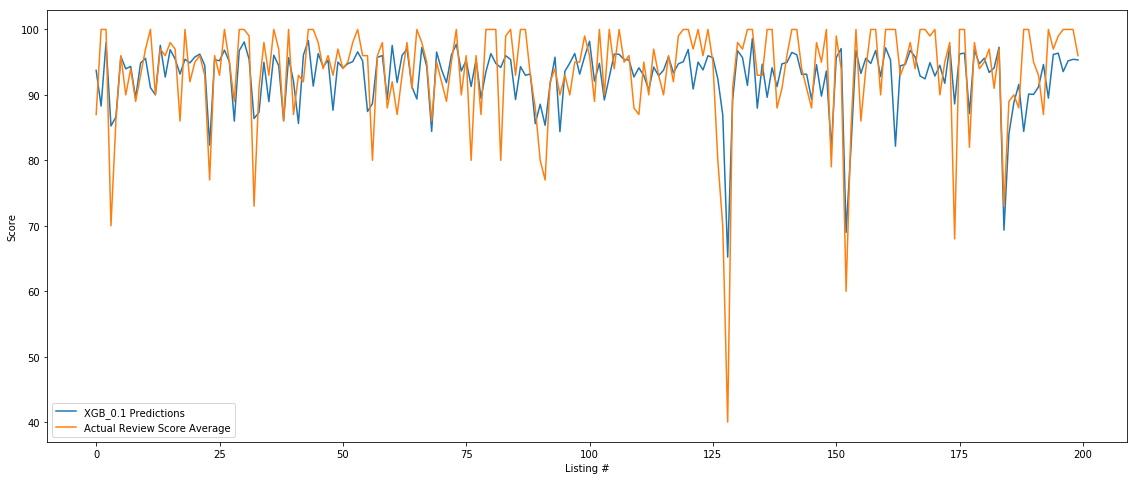

In [23]:
fig5 = plt.figure(figsize=(15,6))
ax5 = fig5.add_axes([0,0,1,1])
ax5.plot(yhat_test[0:200], label='XGB_0.1 Predictions')
ax5.plot(y_test[0:200].reset_index().drop('index',axis=1),label='Actual Review Score Average')
ax5.legend()
ax5.set_ylabel('Score')
ax5.set_xlabel('Listing #')
## Save figure
fig5.savefig('png/Yhat_xgbvsactual.png', bbox_inches='tight');